In [1]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import colormaps as cmaps
import os
import scipy as sp
from scipy.ndimage.interpolation import rotate
from magpie_data import NeLMap, OpticalFrames, PolarimetryMap, FaradayMap, NeLMap2
import scipy.constants as c
from mcerp import N, umath, Gamma

# Figure 1: Setup

In [2]:
cd "~\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s1026_15 Reconnection C TS Outflow 255ns


In [3]:
s1026_15_532=NeLMap('s1026_15 532nm neL.txt', scale=173)
s1026_15_532.set_origin(origin=(1734,2449))

(-4.4000000000000004, 4.4000000000000004, -8.0, 8.0)

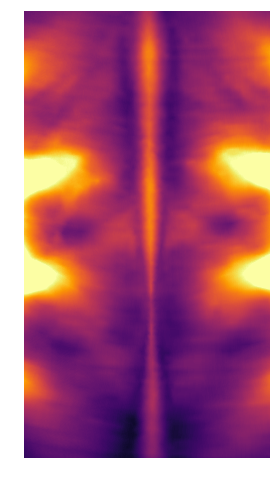

In [4]:
s=s1026_15_532
fig, ax=plt.subplots(figsize=(8,8))
gim=s.plot_neL_mm(ax=ax, clim=[0,2],transpose=True)

ax.set_xlim([-4.4,4.4])
ax.set_ylim([-8,8])
ax.axis('off')

In [5]:
fig.savefig("s1026_15 end on detail.png", dpi=300, bbox_inches='tight')

# Figure 2: Optical Framing

In [52]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s1214_15 C Reconnection 12 Frame\s1214_15\s1214_15 shifted

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s1214_15 C Reconnection 12 Frame\s1214_15\s1214_15 shifted


In [53]:
s=OpticalFrames(188,15)
s.logarithm()
s.rotate(-90+56)
s.crop((512,608), xcrop=230, ycrop=300)

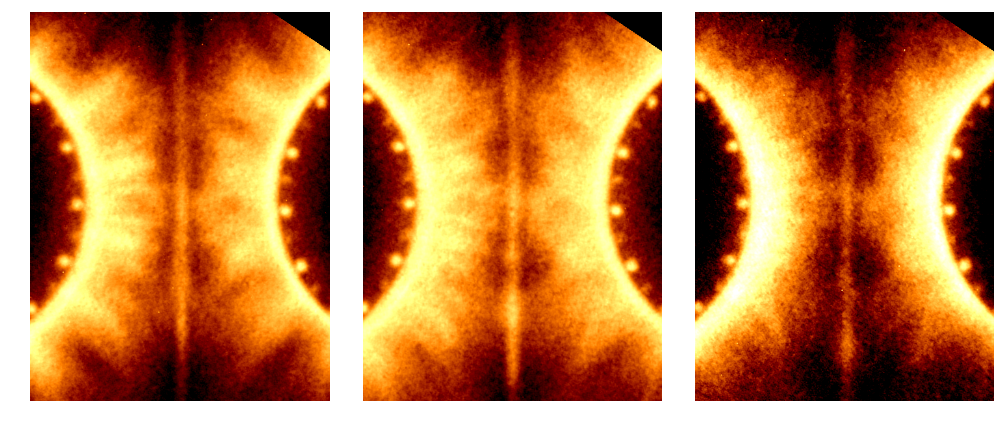

In [57]:
fig, ax=plt.subplots(1,3,figsize=(14,8))
s.plot_crop(frame=10, ax=ax[0], clim=[0.2,1])
s.plot_crop(frame=11, ax=ax[1], clim=[0.2,1.0])
s.plot_crop(frame=12, ax=ax[2], clim=[0.2,0.9])
for a in ax:
    a.set_title('')
fig.tight_layout()

In [59]:
fig.savefig("s1214_15 3 of 12 frames.pdf", dpi=600)

# Figure 3: Interferometry

In [2]:
%cd "~\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s1006_15 Reconnection C TS upstream flow


In [3]:
s1006_15_532=NeLMap2('s1006_15 532nm neL.txt', scale=173, multiply_by=1/1.6, rot_angle=-90)
s1006_15_532.set_origin(origin=(2328,1421), extent=[-11.5,11.5,-8,8])
s1006_15_355=NeLMap2('s1006_15 355nm neL.txt', scale=128, multiply_by=2/1.6, rot_angle=-90,flip_lr=True)
s1006_15_355.set_origin(origin=(1680,1113), extent=[-11.5,11.5,-8,8])

(2112, 512) (2112, 1536)
(832, 512) (832, 1536)
(3719, 882) (259, 882)
(3719, 1211) (259, 1211)


(-10, 10)

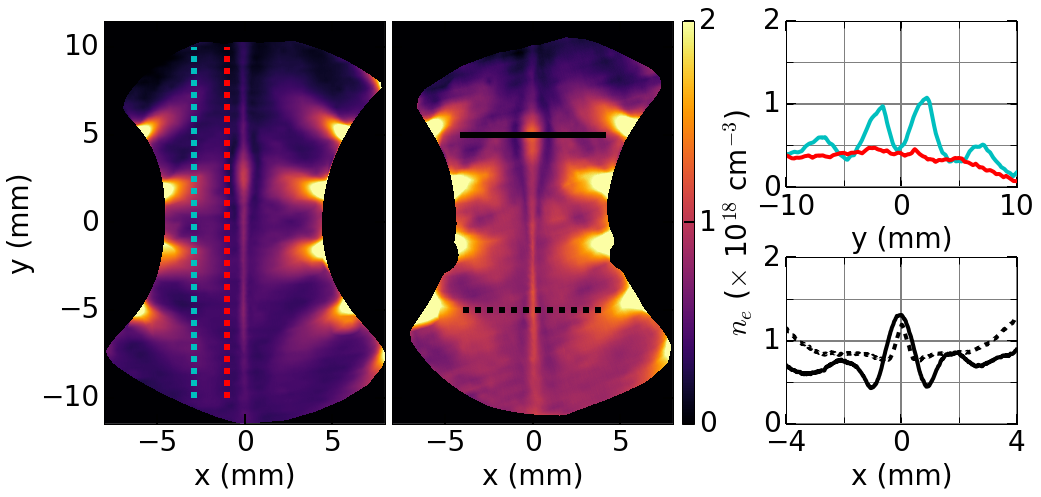

In [7]:
fig=plt.figure(figsize=(16, 7))
ax1=fig.add_axes([0.0, 0.10, 0.3, 0.8])#l,b,w,h
gim=s1006_15_532.plot_data_mm(ax=ax1, clim=[0,2], multiply_by=1e-18)

for x_mm in [-2.9,-1]:
    ax1.plot([x_mm,x_mm],[-10,10], lw=6, ls='dashed')
ax1.lines[0].set_color('c')
ax1.lines[1].set_color('red')

ax2=fig.add_axes([0.25, 0.10, 0.3, 0.8])#l,b,w,h
bim=s1006_15_355.plot_data_mm(ax=ax2, clim=[0,2],multiply_by=1e-18)


ax2.plot([-4,4],[5,5], lw=6, color='black')
ax2.plot([-4,4],[-5,-5], lw=6,  color='k',ls='dashed')


ax1.set_xlabel('x (mm)',fontsize=28)
ax1.set_ylabel('y (mm)',fontsize=28)
ax2.set_xlabel('x (mm)',fontsize=28)
ax2.set_xticks([-5,0,5])
ax1.set_xticks([-5,0,5])

ax1.set_xlim([-8,8])
ax1.set_ylim([-11.5,11.5])

ax2.set_xlim([-8,8])
ax2.set_ylim([-11.5,11.5])


ax1.tick_params(labelsize=28, pad=5, length=10, width=2)
ax2.tick_params(labelsize=28, pad=5, length=10, width=2)
plt.setp(ax2.get_yticklabels(), visible=False)

cbar_ax=fig.add_axes([0.53, 0.10, 0.01, 0.8])#l,b,w,h
cbar_ax.tick_params(labelsize=28, pad=5, length=10, width=2)

fig.colorbar(bim, cax=cbar_ax, ticks=[0.0,1,2])
cbar_ax.set_ylabel(r'$n_e$ ($\times$ 10$^{18}$ cm$^{-3}$)',fontsize=28)


ax4=fig.add_axes([0.62, 0.10, 0.2, 0.33])#l,b,w,h

s=s1006_15_355



s.create_lineout(start=(-5,-4),end=(-5,4), lineout_width=10)
s.plot_lineout(ax=ax4,multiply_by=1e-18)

s.create_lineout(start=(5,-4),end=(5,4), lineout_width=10)
s.plot_lineout(ax=ax4,multiply_by=1e-18)

ax4.lines[1].set_color('black')
ax4.lines[0].set_color('black')
ax4.lines[0].set_linestyle('dashed')



ax4.set_xlim([-4,4])#
ax4.set_xticks([-4,0,4])#
ax4.xaxis.set_minor_locator(MultipleLocator(2))

ax4.set_ylim([0, 2])
ax4.set_yticks([0, 1,2])
ax4.yaxis.set_minor_locator(MultipleLocator(0.5))


ax4.set_xlabel('x (mm)',fontsize=28)
ax4.tick_params(which='minor', pad=5, length=7, width=1)
ax4.tick_params(labelsize=28, pad=5, length=10, width=2)

ax4.grid(which='major', color='gray', linestyle='-', linewidth=2)
ax4.grid(which='minor', color='gray', linestyle='-', linewidth=1)
ax4.set_axisbelow(True)


ax3=fig.add_axes([0.62, 0.57, 0.2, 0.33])#l,b,w,h
s=s1006_15_532

for x_mm in [-2.9,-1]:
    s.create_lineout(start=(-10,x_mm),end=(10,x_mm), lineout_width=10)
    s.plot_lineout(ax=ax3, label="x= "+str(x_mm)+" mm",multiply_by=1e-18)
    
ax3.lines[0].set_color('c')
ax3.lines[1].set_color('red')

ax3.set_xticks([-10,0,10])
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.set_ylim([0, 2])
ax3.set_yticks([0, 1,2])
ax3.yaxis.set_minor_locator(MultipleLocator(0.5))

ax3.grid(which='major', color='gray', linestyle='-', linewidth=2)
ax3.grid(which='minor', color='gray', linestyle='-', linewidth=1)
ax3.set_axisbelow(True)


ax3.tick_params(which='minor', pad=5, length=7, width=1)
ax3.tick_params(labelsize=28, pad=5, length=10, width=2)

ax3.set_xlabel('y (mm)',fontsize=28)
ax3.set_xlim([-10,10])

In [9]:
fig.savefig('s1006_15 nel maps with lineouts.pdf', dpi=300, bbox_inches='tight')

# Figure 4: Faraday
This one is quite involved, we do the full image registration.

In [1]:
cd "~\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat\s0513_15"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat\s0513_15


In [3]:
B0fn="13-May-2015 16_39_56_1355463638_fliplr.png"
B1fn="13-May-2015 16_39_56_2211629970.png"
    S0fn="13-May-2015 17_00_09_1355463638.png"
S1fn="13-May-2015 17_00_09_2211629970.png"
s0513_15_pol=PolarimetryMap(B0fn, B1fn, S0fn, S1fn)
s=s0513_15_pol

In [4]:
s.register()
s.convert_to_alpha()
s.scale=66
s.set_origin((1271,1680), x_range=6.5, y_range=7)

C:\Users\jdavies\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:352: RuntimeWarning: divide by zero encountered in true_divide
  self.N1=self.ST/self.BT
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:352: RuntimeWarning: invalid value encountered in true_divide
  self.N1=self.ST/self.BT
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:356: RuntimeWarning: invalid value encountered in arcsin
  self.alpha=(180/np.pi)*0.5*np.arcsin(self.diff*np.tan(beta)/2.0)


In [5]:
'''
fig, ax=plt.subplots(figsize=(8,8))
far=s.plot_alpha_mm(ax=ax,clim=[-1,1])

ax.set_xlim([s.extent[0],s.extent[1]])
ax.set_ylim([s.extent[2],s.extent[3]])
ax.set_xlabel('x (mm)',fontsize=28)
ax.set_ylabel('y (mm)',fontsize=28)

ax.set_xticks([-6,-3,0,3, 6])
ax.set_yticks([-6,-3,0,3,6])

ax.tick_params(labelsize=28, pad=5, length=10, width=2)

cbar_ax = fig.add_axes([0.9, 0.10, 0.02, 0.8])#l,b,w,h
cbar_ax.tick_params(labelsize=28, pad=5, length=10, width=2)
fig.colorbar(far, cax=cbar_ax, ticks=[-1,0,1])
cbar_ax.set_ylabel(r'Rotation Angle $\alpha$ ($\circ$)',fontsize=28)
'''

"\nfig, ax=plt.subplots(figsize=(8,8))\nfar=s.plot_alpha_mm(ax=ax,clim=[-1,1])\n\nax.set_xlim([s.extent[0],s.extent[1]])\nax.set_ylim([s.extent[2],s.extent[3]])\nax.set_xlabel('x (mm)',fontsize=28)\nax.set_ylabel('y (mm)',fontsize=28)\n\nax.set_xticks([-6,-3,0,3, 6])\nax.set_yticks([-6,-3,0,3,6])\n\nax.tick_params(labelsize=28, pad=5, length=10, width=2)\n\ncbar_ax = fig.add_axes([0.9, 0.10, 0.02, 0.8])#l,b,w,h\ncbar_ax.tick_params(labelsize=28, pad=5, length=10, width=2)\nfig.colorbar(far, cax=cbar_ax, ticks=[-1,0,1])\ncbar_ax.set_ylabel(r'Rotation Angle $\x07lpha$ ($\\circ$)',fontsize=28)\n"

In [6]:
cd ".."

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s0513_15 RECONNECTION - Carbon repeat


In [7]:
s0513_15_far=FaradayMap(s0513_15_pol,"s0513_15 IR side on image registration (2).jpg", "s0513_15 neL side on.txt")

In [8]:
s=s0513_15_far
s.scale_and_crop()
s.register()

C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:402: RuntimeWarning: divide by zero encountered in true_divide
  self.B=5.99e18*self.pm.alpha/self.I1T
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:402: RuntimeWarning: overflow encountered in true_divide
  self.B=5.99e18*self.pm.alpha/self.I1T
C:\Users\jdavies\Documents\magpie-analysis\magpie_data.py:402: RuntimeWarning: invalid value encountered in true_divide
  self.B=5.99e18*self.pm.alpha/self.I1T


In [9]:
np.savetxt('s0513_15 polarisation.txt',s.pm.alpha)

In [9]:
B_av=np.mean(s.B[1200:1400,1380:1980], axis=0)
y_B=np.arange(0,B_av.size)/s0513_15_pol.scale
from lmfit import Model
def Harris(y, y0, B0, L,C):
    return B0*np.tanh((y-y0)/L)+C
hm=Model(Harris, independent_vars='y')
hm.set_param_hint('B0', value = 2)
hm.set_param_hint('y0', value = 0)
hm.set_param_hint('L', value = 0.25)
hm.set_param_hint('C', value = 0)
res=hm.fit(B_av, y=y_B)

 - Adding parameter for hint "B0"
 - Adding parameter for hint "y0"
 - Adding parameter for hint "L"
 - Adding parameter for hint "C"
 - Adding parameter "y0"
 - Adding parameter "B0"
 - Adding parameter "L"
 - Adding parameter "C"


In [10]:
y_Bc=y_B-res.best_values['y0']
B=B_av-res.best_values['C']
hm=Model(Harris, independent_vars='y')
hm.set_param_hint('B0', value = 2)
hm.set_param_hint('y0', value = 0)
hm.set_param_hint('L', value = 0.25)
hm.set_param_hint('C', value = 0)
res=hm.fit(B, y=y_Bc)

 - Adding parameter for hint "B0"
 - Adding parameter for hint "y0"
 - Adding parameter for hint "L"
 - Adding parameter for hint "C"
 - Adding parameter "y0"
 - Adding parameter "B0"
 - Adding parameter "L"
 - Adding parameter "C"


In [11]:
def Harris_j(x, x0, B0, L):
    return -B0/(c.mu_0*L*(np.cosh((x-x0)/L))**2)

B0=2.84
L=0.52e-3
C=0
x0=0
x=np.linspace(-4e-3,4e-3,1000)
j=-Harris_j(x,x0,B0,L)


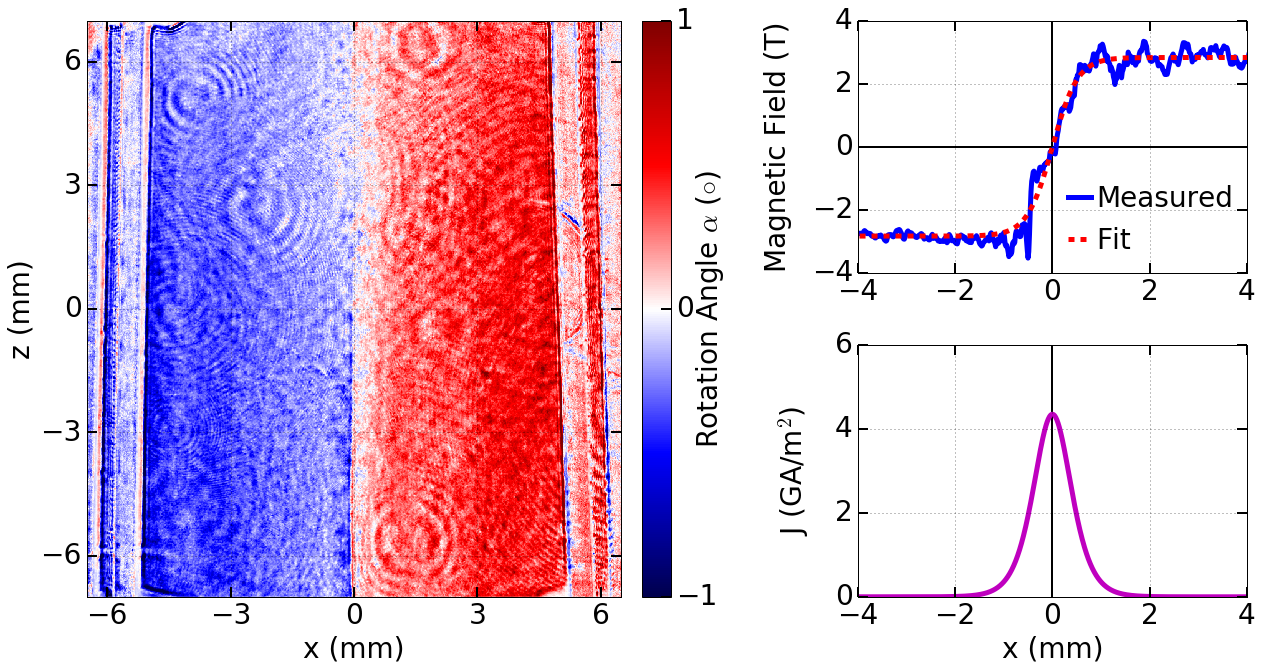

In [46]:
s=s0513_15_pol

fig=plt.figure(figsize=(20,10))

ax=fig.add_axes([0.0, 0.10, 0.4, 0.8])#l,b,w,h

far=s.plot_alpha_mm(ax=ax,clim=[-1,1])

ax.set_xlim([s.extent[0],s.extent[1]])
ax.set_ylim([s.extent[2],s.extent[3]])
ax.set_xlabel('x (mm)',fontsize=28)
ax.set_ylabel('z (mm)',fontsize=28)

ax.set_xticks([-6,-3,0,3, 6])
ax.set_yticks([-6,-3,0,3,6])

ax.tick_params(labelsize=28, pad=5, length=10, width=2)

ax.grid()

cbar_ax = fig.add_axes([0.40, 0.10, 0.02, 0.8])#left,bottom,width,height
cbar_ax.tick_params(labelsize=28, pad=5, length=10, width=2)
fig.colorbar(far, cax=cbar_ax, ticks=[-1,0,1])
cbar_ax.set_ylabel(r'Rotation Angle $\alpha$ ($\circ$)',fontsize=28)

cbar_ax.get_yaxis().set_label_coords(1.8,0.5)


ax2=fig.add_axes([0.55, 0.10, 0.27, 0.35])
ax1=fig.add_axes([0.55, 0.55, 0.27, 0.35])#left,bottom,width,height

ax1.plot([-4, 4], [0, 0], color='k', linewidth=2)
ax1.plot([0, 0], [-4, 4], color='k', linewidth=2)
ax2.plot([0, 0], [0, 6], color='k', linewidth=2)

ax1.plot(y_Bc,B, label='Measured', color='b', lw=5)
ax1.plot(y_Bc,res.best_fit, label='Fit', color='red', lw=5, ls='--')

ax2.plot(x*1e3,j/1e9, lw=5, color='m', label='Electron Density')

ax1.set_xlim([-4,4])
ax1.set_xticks(np.arange(-4,4+1,2))
ax2.set_xlabel('x (mm)', fontsize=28)
ax1.set_ylim([-4,4])
ax1.set_yticks([-4,-2,0,2,4])
ax1.set_ylabel('Magnetic Field (T)',fontsize=28)

ax2.set_ylim([0,6])
ax2.set_yticks([0,2,4,6])
ax2.set_xticks(np.arange(-4,4+1,2))

ax1.get_yaxis().set_label_coords(-0.17,0.5)
ax2.get_yaxis().set_label_coords(-0.12,0.5)

ax1.legend(bbox_to_anchor=(1.03,0.45), 
          frameon=False, 
          fontsize=28,  
          numpoints=1, 
          handletextpad=0.2, 
          handlelength=0.8)


ax2.set_ylabel(r'J (GA/m$^2$)',fontsize=28)
ax1.tick_params(labelsize=28, pad=5, length=10, width=2)
ax2.tick_params(labelsize=28, pad=5, length=10, width=2)
#ax1.set_title(r's0513_15: $B$ and $n_e$',fontsize=40, y=1.02)
ax1.grid()
ax2.grid()
#fig.tight_layout()

In [47]:
fig.savefig('s0513_15 faraday analysis.pdf', dpi=300, bbox_inches='tight')

In [24]:
import csv
data=zip(y_Bc, B, res.best_fit)
headings=['x (mm)', 'B_exp (T)', 'B_fit (T)']
filename='s0513_15 B field lineouts'

with open(filename+'.txt', 'w', newline='') as file:
    cwriter = csv.writer(file, delimiter=',')
    cwriter.writerow(headings)
    for f in data:
        cwriter.writerow(f)

# Figure 5: Thomson Scattering v2

In [2]:
cd "~\Google Drive\MAGPIE\data\2015\s0611_15"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s0611_15


In [3]:
x_pos=[]
n_e=[]
Z=[]
T_e=[]
T_e_err=[]
T_i=[]
T_i_err=[]
V=[]
V_err=[]

filename='s0611_15 TS fits v3.dat'
with open(filename, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    next(reader)
    for row in reader:
        x_pos.append(float(row[3]))
        n_e.append(float(row[5]))
        Z.append(float(row[6]))
        T_e.append(float(row[7]))
        tee=float(row[8])
        if tee==0:
            T_e_err.append(float(row[7])/10.0)
        else:
            T_e_err.append(tee)
        T_i.append(float(row[9]))
        tie=float(row[10])
        if tie==0:
            T_i_err.append(float(row[9])/10.0)
        else:
            T_i_err.append(tie)
        V.append(float(row[11]))
        ve=float(row[12])
        if tie==0:
            V_err.append(float(row[11])/10.0)
        else:
            V_err.append(ve)
        
x=np.array(x_pos)*1e-3
n_e=np.array(n_e)*1e6
n_e_err=(np.zeros_like(n_e)+0.3e17)*1e6 
Z=np.array(Z)
T_e=np.array(T_e)
T_e[11]=15 #set to avg.
T_e_err=np.array(T_e_err)
T_i=np.array(T_i)
T_i_err=np.array(T_i_err)
V=np.array(V)*1e3
V_err=np.array(V_err)*1e3 

In [4]:
def Gamma_mu_sig(mu,sig):
    k=mu**2/sig**2
    theta=sig**2/mu
    return Gamma(k, theta)

G_uv=lambda q, q_err: np.array([Gamma_mu_sig(qq, qe) for qq, qe in zip(q, q_err)])
N_uv=lambda q, q_err: np.array([N(qq, qe) for qq, qe in zip(q, q_err)])

def uv_m_std(uv):
    uv_mean=np.array([u.mean for u in uv])
    uv_std=np.array([u.std for u in uv])
    return uv_mean, uv_std

n_e_uv=N_uv(n_e,n_e_err)
T_e_uv=G_uv(T_e,T_e_err)
T_i_uv=N_uv(T_i,T_i_err)
V_uv=N_uv(V,V_err)

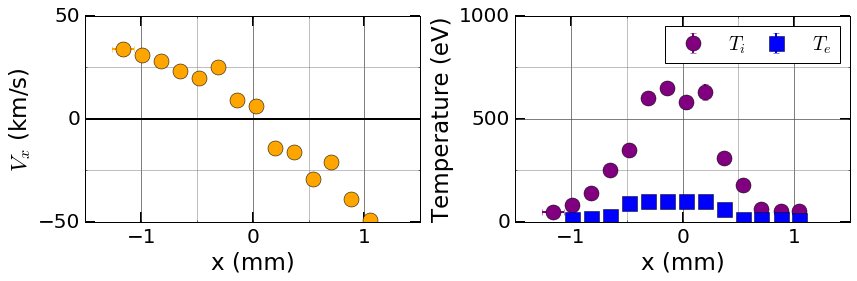

In [5]:
x_mm=x*1e3
x_err=np.zeros_like(x_mm)+0.1
ms=15
lfs=23
tfs=20
elw=2

fig, ax=plt.subplots(1,2,sharex=True,figsize=(12,4))

#single x error_bar per plot

ax[0].errorbar(x_mm[0], xerr=x_err[0], y=(V/1e3)[0], yerr=(V_err/1e3)[0], color='orange', fmt='o',markersize=ms,elinewidth=elw)
ax[1].errorbar(x_mm[0], xerr=x_err[0], y=T_i[0], yerr=T_i_err[0],  color='purple', fmt='o',markersize=ms,elinewidth=elw)
#data points

ax[0].errorbar(x_mm[1:], y=(V/1e3)[1:], yerr=(V_err/1e3)[1:],  label=r'$V_in$', color='orange', fmt='o',markersize=ms,elinewidth=elw)
ax[1].errorbar(x_mm[1:], y=T_i[1:], yerr=T_i_err[1:], label=r'$T_i$', color='purple', fmt='o',markersize=ms,elinewidth=elw)
ax[1].errorbar(x_mm[1:], y=T_e[1:], yerr=T_e_err[1:],label=r'$T_e$', color='blue', fmt='s',markersize=ms,elinewidth=elw)

ax[0].plot([-2,2],[0,0], lw=2, color='black')

a=ax[0]
a.set_xlim([-1.5,1.5])
a.set_xticks([-1,0,1])
a.xaxis.set_minor_locator(MultipleLocator(0.5))

a.set_ylim([-50,50])
a.set_yticks([-50,0,50])
a.yaxis.set_minor_locator(MultipleLocator(25))

a.grid(which='major', color='black', linestyle='-')
a.grid(which='minor', color='gray', linestyle='-')
a.set_axisbelow(True)


a.tick_params(labelsize=tfs, pad=5, length=10, width=2)
a.set_ylabel(r'$V_{x}$ (km/s)', fontsize=lfs)
#a.get_yaxis().set_label_coords(-0.17,0.5)
a.set_xlabel('x (mm)', fontsize=lfs)


a=ax[1]
a.xaxis.set_minor_locator(MultipleLocator(0.5))
a.set_ylim([0,1000])
a.set_yticks([0,500,1000])
a.yaxis.set_minor_locator(MultipleLocator(250))

a.grid(which='major', color='black', linestyle='-')
a.grid(which='minor', color='gray', linestyle='-')
a.set_axisbelow(True)

a.tick_params(labelsize=tfs, pad=5, length=10, width=2)
a.set_ylabel(r'Temperature (eV)', fontsize=lfs)
#a.get_yaxis().set_label_coords(-0.17,0.5)

a.legend(fontsize=20, ncol=2, columnspacing=0.5,numpoints=1)
a.set_xlabel('x (mm)', fontsize=lfs)

fig.tight_layout()

In [45]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\papers\Reconnection Paper"

C:\Users\jdavies\Google Drive\MAGPIE\papers\Reconnection Paper


In [46]:
fig.savefig('thomson data.pdf', dpi=300, bbox_inches='tight')

# Figure 5: Thomson scattering

In [19]:
cd "~\Google Drive\MAGPIE\data\2015\s0611_15"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015\s0611_15


In [6]:
#Energies in J/m^3
m_i=12*c.m_n
B=N(3,0.3)
V_in=N(50e3,5e3)
n_e=N(3e17, 0.6e17)*1e6#m^3
Z=4
n_i=n_e/Z
T_e=N(15,3)*11604#K
T_i=N(50,5)*11604#K

E_kin_in=0.5*m_i*n_i*V_in**2
E_mag_in=B**2/(2*c.mu_0)
E_thi_in=1.5*c.k*n_i*T_i
E_the_in=1.5*c.k*n_e*T_e

L=N(7e-3,0.5e-3)

V_out=N(130e3,5e3)
n_e=N(6e17, 0.6e17)*1e6#m^3
B=0
Z=6
n_i=n_e/Z
T_e=N(100,10)*11604#K
T_i=N(600,60)*11604#K

E_kin_out=0.5*m_i*n_i*V_out**2
E_thi_out=1.5*c.k*n_i*T_i
E_the_out=1.5*c.k*n_e*T_e

d=N(0.6e-3, 0.1e-3)

E_in=np.array([E_mag_in, E_kin_in, E_thi_in, E_the_in])
E_out=np.array([0,E_kin_out, E_thi_out, E_the_out])

rate_in=L*V_in*16e-3
rate_out=d*V_out*16e-3

P_in=E_in*rate_in
P_out=E_out*rate_out

data=np.array([[pin.mean,pout.mean] for pin,pout in zip(P_in,P_out)])
std=np.array([[pin.std,pout.std] for pin,pout in zip(P_in,P_out)])

#data = np.array([1e-6*rate_in*E_in,1e-6*rate_out*E_out])
colors = ('red', 'orange', 'purple', '#3333FF')
labels=[r'$P_{mag}$', '$P_{kin}$',r'$P_{th, i}$',r'$P_{th,e}$']

In [7]:
x_pos=[]
n_e=[]
Z=[]
T_e=[]
T_e_err=[]
T_i=[]
T_i_err=[]
V=[]
V_err=[]

filename='s0611_15 TS fits v3.dat'
with open(filename, 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    next(reader)
    for row in reader:
        x_pos.append(float(row[3]))
        n_e.append(float(row[5]))
        Z.append(float(row[6]))
        T_e.append(float(row[7]))
        tee=float(row[8])
        if tee==0:
            T_e_err.append(float(row[7])/10.0)
        else:
            T_e_err.append(tee)
        T_i.append(float(row[9]))
        tie=float(row[10])
        if tie==0:
            T_i_err.append(float(row[9])/10.0)
        else:
            T_i_err.append(tie)
        V.append(float(row[11]))
        ve=float(row[12])
        if tie==0:
            V_err.append(float(row[11])/10.0)
        else:
            V_err.append(ve)
        
x=np.array(x_pos)*1e-3
n_e=np.array(n_e)*1e6
n_e_err=(np.zeros_like(n_e)+0.3e17)*1e6 
Z=np.array(Z)
T_e=np.array(T_e)
T_e[11]=15 #set to avg.
T_e_err=np.array(T_e_err)
T_i=np.array(T_i)
T_i_err=np.array(T_i_err)
V=np.array(V)*1e3
V_err=np.array(V_err)*1e3 

In [8]:
def Gamma_mu_sig(mu,sig):
    k=mu**2/sig**2
    theta=sig**2/mu
    return Gamma(k, theta)

G_uv=lambda q, q_err: np.array([Gamma_mu_sig(qq, qe) for qq, qe in zip(q, q_err)])
N_uv=lambda q, q_err: np.array([N(qq, qe) for qq, qe in zip(q, q_err)])

def uv_m_std(uv):
    uv_mean=np.array([u.mean for u in uv])
    uv_std=np.array([u.std for u in uv])
    return uv_mean, uv_std

n_e_uv=N_uv(n_e,n_e_err)
T_e_uv=G_uv(T_e,T_e_err)
T_i_uv=N_uv(T_i,T_i_err)
V_uv=N_uv(V,V_err)

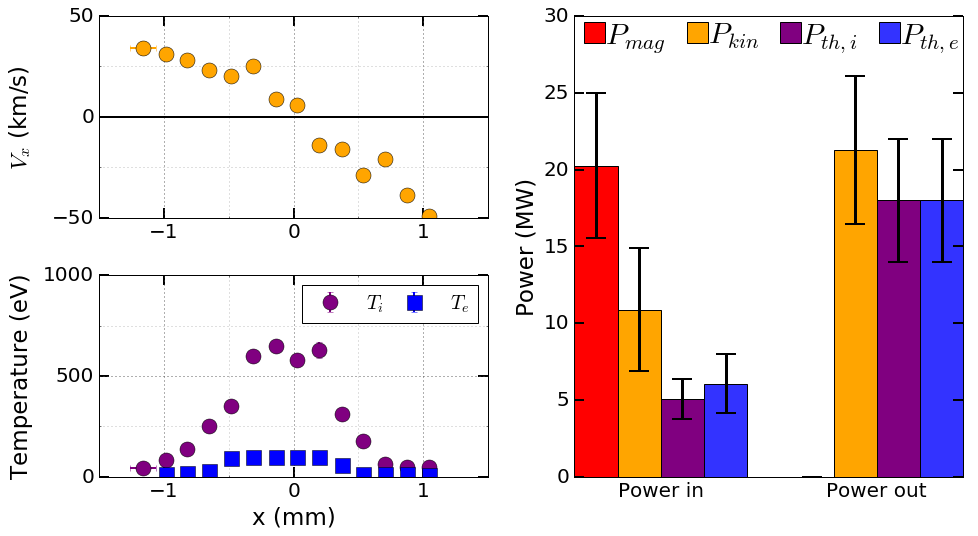

In [10]:
x_mm=x*1e3
x_err=np.zeros_like(x_mm)+0.1
ms=15
lfs=23
tfs=20
elw=2

fig=plt.figure(figsize=(12,8))

a1=fig.add_axes([0, 0.10, 0.45, 0.35])
a0=fig.add_axes([0, 0.55, 0.45, 0.35])#left,bottom,width,height
a2=fig.add_axes([0.55, 0.1, 0.45, 0.8])#left,bottom,width,height



#single x error_bar per plot

a0.errorbar(x_mm[0], xerr=x_err[0], y=(V/1e3)[0], yerr=(V_err/1e3)[0], color='orange', fmt='o',markersize=ms,elinewidth=elw)
a1.errorbar(x_mm[0], xerr=x_err[0], y=T_i[0], yerr=T_i_err[0],  color='purple', fmt='o',markersize=ms,elinewidth=elw)

#data points

a0.errorbar(x_mm[1:], y=(V/1e3)[1:], yerr=(V_err/1e3)[1:],  label=r'$V_in$', color='orange', fmt='o',markersize=ms,elinewidth=elw)
a1.errorbar(x_mm[1:], y=T_i[1:], yerr=T_i_err[1:], label=r'$T_i$', color='purple', fmt='o',markersize=ms,elinewidth=elw)
a1.errorbar(x_mm[1:], y=T_e[1:], yerr=T_e_err[1:],label=r'$T_e$', color='blue', fmt='s',markersize=ms,elinewidth=elw)

a0.plot([-2,2],[0,0], lw=2, color='black')

a=a0
a.set_xlim([-1.5,1.5])
a.set_xticks([-1,0,1])
a.xaxis.set_minor_locator(MultipleLocator(0.5))

a.set_ylim([-50,50])
a.set_yticks([-50,0,50])
a.yaxis.set_minor_locator(MultipleLocator(25))

a.grid()
a.grid(which='minor', color='gray',linestyle=':')

a.tick_params(labelsize=tfs, pad=5, length=10, width=2)
a.set_ylabel(r'$V_{x}$ (km/s)', fontsize=lfs)
a.get_yaxis().set_label_coords(-0.17,0.5)

a.set_axisbelow(True)

a=a1
a.xaxis.set_minor_locator(MultipleLocator(0.5))
a.grid(which='minor', color='gray',linestyle=':')

a.set_ylim([0,1000])
a.set_yticks([0,500,1000])
a.set_xticks([-1,0,1])

a.yaxis.set_minor_locator(MultipleLocator(250))

a.grid()
a.tick_params(labelsize=tfs, pad=5, length=10, width=2)
a.set_ylabel(r'Temperature (eV)', fontsize=lfs)
a.get_yaxis().set_label_coords(-0.17,0.5)

a.legend(fontsize=20, ncol=2, columnspacing=0.5,numpoints=1)
a.set_xlabel('x (mm)', fontsize=lfs)

a.set_axisbelow(True)

ax=a2

ekw={'ecolor':'black', 'elinewidth':3, 'capsize':10, 'capthick':2}

width=0.1
ind=np.array([0,0.5])

for i in range(0,4):
    ax.bar(ind+i*width, data[i]/1e6,width,yerr=std[i]/1e6,color=colors[i], label=labels[i], error_kw=ekw)

ax.set_xticks([0.2,0.7])
ax.set_xticklabels(['Power in','Power out'])
ax.set_xlim(0,0.9)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax.set_ylim([0,30])
ax.set_ylabel('Power (MW)', fontsize=lfs)
ax.tick_params(labelsize=tfs, pad=5, length=10, width=2)


ax.legend(bbox_to_anchor=(1.06, 1.05), 
          ncol=4, 
          fontsize=30, 
          frameon=False, 
          columnspacing=0.7,
          numpoints=1, 
          handletextpad=0.0, 
          handlelength=0.7)
#fig.tight_layout()

In [11]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\papers\Reconnection Paper"

C:\Users\jdavies\Google Drive\MAGPIE\papers\Reconnection Paper


In [12]:
fig.savefig('thomson data and power balance.pdf', dpi=300, bbox_inches='tight')

In [25]:
P_inT=P_in.sum()
P_outT=P_out.sum()
DeltaP=P_inT-P_outT
print(DeltaP.mean/1e6, DeltaP.std/1e6)

-15.0779835774 15.3969615912


# Errors for bar chart

In [60]:
#Energies in J/m^3
m_i=12*c.m_n
B=N(3,0.3)
V_in=N(50e3,5e3)
n_e=N(3e17, 0.6e17)*1e6#m^3
Z=4
n_i=n_e/Z
T_e=N(15,3)*11604#K
T_i=N(50,5)*11604#K

E_kin_in=0.5*m_i*n_i*V_in**2
E_mag_in=B**2/(2*c.mu_0)
E_thi_in=1.5*c.k*n_i*T_i
E_the_in=1.5*c.k*n_e*T_e

L=N(7e-3,1e-3)

V_out=N(130e3,5e3)
n_e=N(6e17, 0.6e17)*1e6#m^3
B=0
Z=6
n_i=n_e/Z
T_e=N(100,10)*11604#K
T_i=N(600,60)*11604#K

E_kin_out=0.5*m_i*n_i*V_out**2
E_thi_out=1.5*c.k*n_i*T_i
E_the_out=1.5*c.k*n_e*T_e

d=N(0.6e-3, 0.1e-3)

E_in=np.array([E_mag_in, E_kin_in, E_thi_in, E_the_in])
E_out=np.array([0,E_kin_out, E_thi_out, E_the_out])

rate_in=L*V_in*16e-3
rate_out=d*V_out*16e-3

P_in=E_in*rate_in
P_out=E_out*rate_out

data=np.array([[pin.mean,pout.mean] for pin,pout in zip(P_in,P_out)])
std=np.array([[pin.std,pout.std] for pin,pout in zip(P_in,P_out)])

#data = np.array([1e-6*rate_in*E_in,1e-6*rate_out*E_out])
colors = ('red', 'orange', 'purple', '#3333FF')
labels=[r'$P_{mag}$', '$P_{kin}$',r'$P_{th, i}$',r'$P_{th,e}$']

In [77]:
P_inT=P_in.sum()
P_outT=P_out.sum()

In [81]:
(P_inT-P_outT).mean/1e6, (P_inT-P_outT).std/1e6

(-15.058008502968832, 16.405308795767031)

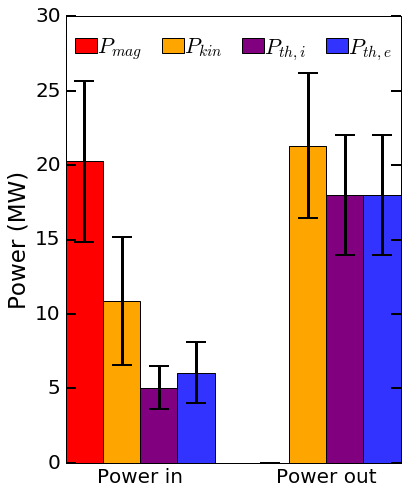

In [86]:
#side by side bar chart

fig, ax=plt.subplots(figsize=(6,8))

ekw={'ecolor':'black', 'elinewidth':3, 'capsize':10, 'capthick':2}

width=0.1
ind=np.array([0,0.5])

for i in range(0,4):
    ax.bar(ind+i*width, data[i]/1e6,width,yerr=std[i]/1e6,color=colors[i], label=labels[i], error_kw=ekw)

ax.set_xticks([0.2,0.7])
ax.set_xticklabels(['Power in','Power out'])
ax.set_xlim(0,0.9)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax.set_ylim([0,30])
ax.set_ylabel('Power (MW)', fontsize=lfs)
ax.tick_params(labelsize=tfs, pad=5, length=10, width=2)


ax.legend(loc=9, ncol=4, fontsize=22, frameon=False, columnspacing=0.9,numpoints=1, handletextpad=0.0, handlelength=1)

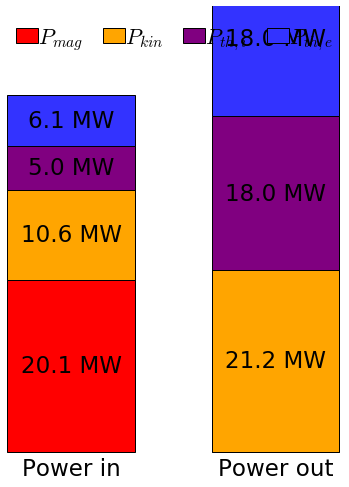

In [30]:
##stack plot

fig, ax=plt.subplots(figsize=(6,8))

width=0.5
ind=(0,0.8)

ax.bar(ind, data[:,0], width,color=colors[0], label=labels[0])
ax.text(0+width/2, data[0,0]/2, str(round(data[0,0],1))+' MW', fontsize=23, va='center', ha='center')

for j in range(1, data.shape[1]):
    ax.bar(ind, data[:,j], width,color=colors[j], label=labels[j],bottom=bottom[:,j-1])
    for i in (0,1):
        ax.text(ind[i]+width/2, data[i,j]/2+bottom[i,j-1], str(round(data[i,j],1))+' MW', fontsize=23, va='center', ha='center')

ax.set_xticks([width/2.0,ind[1]+width/2.0])
ax.set_xticklabels(['Power in','Power out'], fontsize=23)
ax.set_xlim(0,1.31)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='off') # labels along the bottom edge are off

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_ylim([-0.1,52])

ax.legend(loc=9, ncol=4, fontsize=22, frameon=False, columnspacing=0.9,numpoints=1, handletextpad=0.0, handlelength=1)

In [213]:
ind

array([0, 1, 2, 3, 4])